In [1]:
import mlflow
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import imutils
from mlflow import MlflowClient

In [ ]:
#import os
#os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = r'C:\Users\Clsm\Documents\GitHub\prompts-generate-ai\service_acc\sktblog-GOOGLE_APPLICATION_CREDENTIALS.json'

In [2]:
#mlflow.set_tracking_uri("http://34.173.115.10:8888")
mlflow.set_tracking_uri("sqlite:///mlflow.db")

## Loading Datasets

In [3]:
train_dir = r'C:\Users\Clsm\fruit_dataset\train'
test_dir = r'C:\Users\Clsm\fruit_dataset\test'

In [4]:
train_datagen = ImageDataGenerator(rescale= 1./255)
test_datagen = ImageDataGenerator(rescale= 1./255)

In [5]:
batch_size = 16
train_set = train_datagen.flow_from_directory(train_dir,
                                            target_size= (100,100),
                                            batch_size = batch_size,
                                            class_mode = 'categorical')
test_set = test_datagen.flow_from_directory(test_dir,
                                            target_size = (100,100),
                                            batch_size = batch_size,
                                            class_mode = 'categorical')

Found 2301 images belonging to 10 classes.
Found 1025 images belonging to 10 classes.


## Model Creating

In [6]:
IMAGE_SIZE = [100,100]
vgg = VGG19(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
#do not train the pre-trained layers of VGG-19
for layer in vgg.layers:
    layer.trainable = False
x = Flatten()(vgg.output)
#adding output layer.Softmax classifier is used as it is multi-class classification
prediction = Dense(10, activation='softmax')(x)

model = Model(inputs=vgg.input, outputs=prediction)

In [7]:
model.compile(
  loss='categorical_crossentropy',
  optimizer="adam",
  metrics=['accuracy']
)

## Model train and save in ML flow

In [10]:
from sklearn.linear_model import Lasso
from sklearn.metrics import accuracy_score
import pickle
mlflow.sklearn.autolog()
with mlflow.start_run() as run:
    mlflow.set_tag("developer", "epm")
    mlflow.set_tag("version", "prerelease")

    mlflow.log_param('dataset' , 'fruit_classification')
    mlflow.log_param('train_amount', '2301images')
    mlflow.log_param('test_amount', '1025images')
    hist = model.fit(train_set, batch_size = batch_size, epochs= 1)
    mlflow.sklearn.log_model(hist, artifact_path="fruits-model_test_1")

name = "fruit_classification_test_1"
client = MlflowClient()
client.create_registered_model(name)

2023/03/16 16:00:22 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.


144/144 [==============================] - 255s 2s/step - loss: 0.9243 - accuracy: 0.6975
INFO:tensorflow:Assets written to: ram://d58f84ec-3260-48a8-b339-5832b7fe284c/assets


2023/03/16 16:04:42 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/03/16 16:04:52 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\Clsm\AppData\Local\Temp\tmpzzyqw9ky\model\model.pkl, flavor: sklearn), fall back to return ['scikit-learn==1.2.0', 'cloudpickle==2.2.0']. Set logging level to DEBUG to see the full traceback.


<RegisteredModel: creation_timestamp=1678959292350, description=None, last_updated_timestamp=1678959292350, latest_versions=[], name='fruit_classification_test_1', tags={}>

## Creating Model Version

In [11]:
run_id = run.info.run_id
model_uri = "runs:/{}/sklearn-model".format(run_id)
mv = client.create_model_version(name, model_uri, run_id)
print("model version {} created".format(mv.version))

2023/03/16 16:06:53 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: fruit_classification_test_1, version 1


model version 1 created


In [12]:
new_stage = 'Archived'
model_version = 1
client.transition_model_version_stage(
    name = name,
    version = model_version,
    stage = new_stage,
    archive_existing_versions=False
)

<ModelVersion: creation_timestamp=1678959413180, current_stage='Archived', description=None, last_updated_timestamp=1678959416363, name='fruit_classification_test_1', run_id='84b93b6b8f2d47698601a3fd3ffa892e', run_link=None, source='runs:/84b93b6b8f2d47698601a3fd3ffa892e/sklearn-model', status='READY', status_message=None, tags={}, user_id=None, version=1>

## Creating another version

In [14]:
with mlflow.start_run() as run1:
    hist = model.fit(train_set, epochs=2, batch_size = 32)
    mlflow.sklearn.log_model(hist, artifact_path="fruits-model_test1")

model_uri = f"runs:/{run_id}/fruits-model_test_1"
mlflow.register_model(model_uri=model_uri,name=name)

Epoch 1/2
144/144 [==============================] - 220s 2s/step - loss: 0.6900 - accuracy: 0.7862
Epoch 2/2
144/144 [==============================] - 235s 2s/step - loss: 0.5448 - accuracy: 0.8431
INFO:tensorflow:Assets written to: ram://3a721d54-3ae1-49e1-9983-3a85e80d6ca4/assets


2023/03/16 16:15:55 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/03/16 16:16:05 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\Clsm\AppData\Local\Temp\tmpw4bss7hm\model\model.pkl, flavor: sklearn), fall back to return ['scikit-learn==1.2.0', 'cloudpickle==2.2.0']. Set logging level to DEBUG to see the full traceback.
Registered model 'fruit_classification_test_1' already exists. Creating a new version of this model...
2023/03/16 16:16:05 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: fruit_classification_test_1, version 2
Created version '2' of model 'fruit_classification_test_1'.


<ModelVersion: creation_timestamp=1678959965112, current_stage='None', description=None, last_updated_timestamp=1678959965112, name='fruit_classification_test_1', run_id='84b93b6b8f2d47698601a3fd3ffa892e', run_link=None, source='./mlruns/0/84b93b6b8f2d47698601a3fd3ffa892e/artifacts/fruits-model_test_1', status='READY', status_message=None, tags={}, user_id=None, version=2>

In [15]:
version = 2
new_stage = 'Staging'
client.transition_model_version_stage(
    name = name, 
    version= version,
    stage= new_stage,
    archive_existing_versions=False
)

<ModelVersion: creation_timestamp=1678959965112, current_stage='Staging', description=None, last_updated_timestamp=1678960001198, name='fruit_classification_test_1', run_id='84b93b6b8f2d47698601a3fd3ffa892e', run_link=None, source='./mlruns/0/84b93b6b8f2d47698601a3fd3ffa892e/artifacts/fruits-model_test_1', status='READY', status_message=None, tags={}, user_id=None, version=2>

In [16]:
model_versions = client.get_latest_versions(name= name)
for version in model_versions:
    print(f"version:{version.version}, stage:{version.current_stage}")

version:1, stage:Archived
version:2, stage:Staging


In [35]:
artifact = []
def fetch_logged_data(run_id):
    client = MlflowClient()
    data = client.get_run(run_id).data
    tags = {k: v for k, v in data.tags.items() if not k.startswith("mlflow.")}
    #artifacts = [f.path for f in client.list_artifacts(run_id,'fruits-model_test1')]
    for f in client.list_artifacts(run_id,'fruits-model_test_1'):
        artifact.append(f.path)
    return data.params, data.metrics, tags, artifact
params, metrics, tags, artifact = fetch_logged_data(run_id=run_id)

In [36]:
from pprint import pprint
pprint(artifact)

['fruits-model_test_1/MLmodel',
 'fruits-model_test_1/conda.yaml',
 'fruits-model_test_1/model.pkl',
 'fruits-model_test_1/python_env.yaml',
 'fruits-model_test_1/requirements.txt']


## Model loading and evaluation

In [45]:
run_id = run1.info.run_id
run_id

'0b864c7495eb4c6daa061b9e97df2417'

In [46]:
from mlflow.store.artifact.runs_artifact_repo import RunsArtifactRepository
runs_uri = "runs:/0b864c7495eb4c6daa061b9e97df2417/fruits-model_test"
model_src = RunsArtifactRepository.get_underlying_uri(runs_uri)
model_src

'./mlruns/0/0b864c7495eb4c6daa061b9e97df2417/artifacts/fruits-model_test'

In [55]:
stage = 'Archived'
version = 1
model_path = f"models:/{name}/{version}"
model = mlflow.sklearn.load_model(model_path)

OSError: No such file or directory: '.\mlruns\0\0b864c7495eb4c6daa061b9e97df2417\artifacts\fruits-model_test_1'

(100, 100, 3)


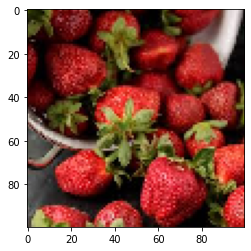

In [56]:
import matplotlib.pyplot as plt
import numpy as np
test_img = None
test_label = None
for image,label in test_set:
    test_img = image[0]
    test_label = label[0]
    break
print(test_img.shape)
plt.imshow(test_img)

In [ ]:
img = np.array([test_img])
model.predict(img,batch_size=1)